## Note to the Reader

1) To keep this explainer notebook as clean and readable as possible, several longer Python functions have been moved to separate files located in the `/utilities` folder.



2) Our full project, including code and website source code, is publicly available on GitHub:
`https://github.com/Andreas-Holm-2/02467-Project-assignment`

3) The datasets used in this project can be accessed here:


*Spotify Artist Collaboration Network (Large Dataset):*

- `https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVc`

*US Top 10K Artists and Their Popular Songs (Smaller Dataset):*

`https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs`

## Motivation 

As music plays a significant role in most people’s lives-including our own-it was naturally intriguing for us to explore this domain. The goal of this project is to investigate whether there are any significant differences in the way artists within different music genres collaborate. More specifically, we were interested in examining whether collaboration patterns differ between the two highly collaborative genres: pop and rap. We hypothesize that these patterns do indeed vary, and we aim to explore what this reveals about the culture within each genre. We believe that network science is the perfect tool to help us answer this question.

In this project, we constructed our own dataset by utilizing two different sources. The first was a large dataset containing approximately 156,000 artists and recorded collaborations between them. We found this dataset ideal for our project, as it included the key features we needed: artist names, follower counts (allowing us to filter out smaller or duplicate artists), and genre labels (enabling us to compare genres within the network).

In addition, we used a smaller dataset containing a list of the 10,000 most listened-to artists within the US. This dataset allowed us to narrow our analytical focus, excluding less influential or smaller artists. We intersected this list with the larger dataset to retain only relevant artists. Various additional preprocessing steps were employed to ensure a clean and usable dataset, which are described further below.

Our datasets did not naturally contain any text-data. To address this, we used our knowledge from class to leverage the Genius API in order to collect lyrics for each artist. Our approach was to gather lyrics from each artist’s three most popular songs, as these are typically the best representations of their musical style and identity.

In [3]:
# Import of the most central dependicies
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np
import re
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.stats import chi2
from nltk.tokenize import MWETokenizer
from wordcloud import WordCloud
import math
import pickle 

import sys
sys.dont_write_bytecode = True


## Loading the datasets

In [4]:
# Spotify Artist Collaboration Network (Large Dataset)
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
nodes_df

spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
2                                                      []   
3       [dancehall, lovers rock, modern reggae, reggae...   
4       [classic swedish pop, norrbotten indie, swedis...   
...                                                   ...   
156417                              [classic swedish pop]   
156418                                                 []   
156419                                                 []   
156420                                                 []   
156421                                                 []   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
2                                              ['de (1)']  
3                                    ['at (1)', 'de (1)']  
4                                              ['se (6)']  
...                                                   ...  
156417                                                NaN  
156418                                                NaN  
156419                                                NaN  
156420                                                NaN  
156421                                                NaN  

[156422 rows x 6 columns]

In [5]:
# US Top 10K Artists:
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_df

ID  Gender  Age Country  \
Name                                                              
Drake               3TVXtAsR1Inumwj472S9r4    male   33      CA   
Post Malone         246dkjvS1zLTtiykXe5h60    male   25      US   
Ed Sheeran          6eUKZXaKkcviH0Ku9w2n3V    male   29      GB   
J Balvin            1vyhD5VmyZ7KMfW5gqLgo5    male   35      CO   
Bad Bunny           4q3ewBCX7sLwd24euuV69X    male   26      PR   
...                                    ...     ...  ...     ...   
IVAN$ITO            0cPmSFfjpop7imPVWSk2yc     NaN    0     NaN   
Antonello Venditti  3hYLJPJuDyblFKersEaFd6    male   71      IT   
Lea Salonga         1GlMjIezcLwV3OFlX0uXOv  female   49      PH   
Vertical Horizon    6Hizgjo92FnMp8wGaRUNTn   mixed   29     NaN   
Lakko               48wDYb8J9emrtnfRJvYEdZ    male    0      ES   

                                                               Genres  \
Name                                                                    
Drake               ['canadian hip hop', 'canadian pop', 'hip hop'...   
Post Malone                  ['dfw rap', 'melodic rap', 'pop', 'rap']   
Ed Sheeran                 ['pop', 'singer-songwriter pop', 'uk pop']   
J Balvin            ['reggaeton', 'reggaeton colombiano', 'trap la...   
Bad Bunny               ['reggaeton', 'trap latino', 'urbano latino']   
...                                                               ...   
IVAN$ITO                                                           []   
Antonello Venditti  ["canzone d'autore", 'classic italian pop', 'i...   
Lea Salonga                        ['movie tunes', 'tagalog worship']   
Vertical Horizon            ['neo mellow', 'pop rock', 'post-grunge']   
Lakko                                                              []   

                    Popularity  Followers  \
Name                                        
Drake                       95   83298497   
Post Malone                 86   43130108   
Ed Sheeran                  87  115998928   
J Balvin                    83   38028010   
Bad Bunny                   95   77931484   
...                        ...        ...   
IVAN$ITO                    20       4249   
Antonello Venditti          54     778642   
Lea Salonga                 56     179832   
Vertical Horizon            48     431277   
Lakko                       21      21571   

                                                      URI  
Name                                                       
Drake               spotify:artist:3TVXtAsR1Inumwj472S9r4  
Post Malone         spotify:artist:246dkjvS1zLTtiykXe5h60  
Ed Sheeran          spotify:artist:6eUKZXaKkcviH0Ku9w2n3V  
J Balvin            spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5  
Bad Bunny           spotify:artist:4q3ewBCX7sLwd24euuV69X  
...                                                   ...  
IVAN$ITO            spotify:artist:0cPmSFfjpop7imPVWSk2yc  
Antonello Venditti  spotify:artist:3hYLJPJuDyblFKersEaFd6  
Lea Salonga         spotify:artist:1GlMjIezcLwV3OFlX0uXOv  
Vertical Horizon    spotify:artist:6Hizgjo92FnMp8wGaRUNTn  
Lakko               spotify:artist:48wDYb8J9emrtnfRJvYEdZ  

[9488 rows x 8 columns]

In [6]:
artists_us_name_list = (artists_us_df.index).tolist() # Convert the list of names into list allowing us to find the intersection next
print(artists_us_name_list[:5]) # Security check

['Drake', 'Post Malone', 'Ed Sheeran', 'J Balvin', 'Bad Bunny']


## Finding the intersection betwen the two datasets

We will now be constructing our dataset as a intersection between the large spotify collaration dataset and `artists_us_name_list`

In [7]:
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
nodes_df

spotify_id           name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4      Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK       Kontra K  1999676.0          72   
15      3xs0LEzcPXtgNfMNcHzLIP       Rockwell    40344.0          58   
20      2NUz5P42WqkxilbI8ocN76    Vybz Kartel  1026598.0          63   
22      4Lm0pUvmisUHMdoky5ch2I   Apocalyptica   864846.0          60   
...                        ...            ...        ...         ...   
156038  7p5J8SfKU9Rulp7tcA53G8     Jose Merce   182186.0          51   
156119  3gJ0f9ov2Vjrbo9RnFFH76          Endor      267.0           2   
156199  7mKmqnXqn1WoEFljKyvAHR        2T FLOW       20.0          29   
156220  6kT18gnkVrCz8xJQcrib7L        Bhaskar   230894.0          60   
156330  0Wkm45quqfx3NepJpXDvwE  Superorganism   225468.0          51   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
15                                                     []   
20         [dancehall, jamaican dancehall, reggae fusion]   
22      [alternative metal, bow pop, cello, finnish me...   
...                                                   ...   
156038  [cante flamenco, flamenco, nuevo flamenco, rumba]   
156119                              [scottish indie folk]   
156199                                                 []   
156220   [brazilian bass, brazilian edm, brazilian house]   
156330                                          [art pop]   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
15      ['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...  
20                                   ['cr (3)', 'pa (1)']  
22                                             ['fi (2)']  
...                                                   ...  
156038                                                NaN  
156119                                                NaN  
156199                                                NaN  
156220                                                NaN  
156330                                                NaN  

[9754 rows x 6 columns]

By inspecting the dataframe, we notice there are more artists in the intersection (9,754) than in the dataset containing the most listened artists in the US (9,488). This indicates there are duplicates in the dataset. We will inspect this:

In [6]:
# Sorting for duplicated within the intersection
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")
duplicate_names

spotify_id             name  followers  popularity  \
43592   1ItNxpDdetHb2gyS10HKfF         18 Karat     1644.0          18   
13282   5oWFxbBrbk2Mw86PLUg3OZ         18 Karat   292544.0          53   
57139   09ZUMxxU5pgzUF0FtHeGXG         19HUNNID        5.0           1   
59493   2Zm4abMQXwcrsM9IWY3AoB         19HUNNID      513.0          31   
156199  7mKmqnXqn1WoEFljKyvAHR          2T FLOW       20.0          29   
...                        ...              ...        ...         ...   
146823  1wEQjEpK6KfE9Et2ZZBfPa           Żabson       43.0           4   
24780   0FtUnl4AjR5eDa1v77WU0b  ปู่จ๋าน ลองไมค์      138.0          17   
95174   23YWwPEvaO5HLqEMgiUXJa  ปู่จ๋าน ลองไมค์    23424.0          32   
6081    3dTgjg7lzUGiD3NwcGCK1n               阿冗    44494.0          48   
8241    7sD5pBZNNSDMfiF2BvRem7               阿冗      671.0          31   

                                                   genres  \
43592                                                  []   
13282   [deep german hip hop, german hip hop, german u...   
57139                                                  []   
59493                                         [thai trap]   
156199                                                 []   
...                                                   ...   
146823                                                 []   
24780                                                  []   
95174                                                  []   
6081            [chinese viral pop, mainland chinese pop]   
8241                                                   []   

                                         chart_hits  
43592                                           NaN  
13282   ['at (16)', 'de (30)', 'lu (3)', 'ch (12)']  
57139                                           NaN  
59493                                           NaN  
156199                                          NaN  
...                                             ...  
146823                                          NaN  
24780                                           NaN  
95174                                           NaN  
6081                 ['my (1)', 'sg (1)', 'tw (4)']  
8241                                     ['tw (1)']  

[1739 rows x 6 columns]

As we can see, there are a large number of duplicate names. This is likely due to the size of the Spotify dataset, which contains more than 156,000 artists. It is also a consequence of spotify names which are not unique, meaning many small and  negligible artists are included in our dataframe. 

For example on spotify, consider the user `Drake`  who is in the top 10.000. Since the spotify names are not unique some negligible small spotify user could use the `Drake` name aswell and be included in our filtering process. To address this, we will apply a simple algorithm: for duplicate names, we will keep only the artist with the most Spotify followers.

In [7]:
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")
final_cleaned_nodes_df

spotify_id            name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4       Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK        Kontra K  1999676.0          72   
15      3xs0LEzcPXtgNfMNcHzLIP        Rockwell    40344.0          58   
20      2NUz5P42WqkxilbI8ocN76     Vybz Kartel  1026598.0          63   
22      4Lm0pUvmisUHMdoky5ch2I    Apocalyptica   864846.0          60   
...                        ...             ...        ...         ...   
155870  3a9qv6NLHnsVxJUtKOMHvD  The Glitch Mob   538974.0          61   
156036  7dh6G6qILmRpUtZU4ZSD4D        Trobeats      515.0           9   
156038  7p5J8SfKU9Rulp7tcA53G8      Jose Merce   182186.0          51   
156220  6kT18gnkVrCz8xJQcrib7L         Bhaskar   230894.0          60   
156330  0Wkm45quqfx3NepJpXDvwE   Superorganism   225468.0          51   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
15                                                     []   
20         [dancehall, jamaican dancehall, reggae fusion]   
22      [alternative metal, bow pop, cello, finnish me...   
...                                                   ...   
155870  [edm, electro house, glitch, glitch hop, indie...   
156036                                                 []   
156038  [cante flamenco, flamenco, nuevo flamenco, rumba]   
156220   [brazilian bass, brazilian edm, brazilian house]   
156330                                          [art pop]   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
15      ['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...  
20                                   ['cr (3)', 'pa (1)']  
22                                             ['fi (2)']  
...                                                   ...  
155870                                                NaN  
156036                                                NaN  
156038                                                NaN  
156220                                                NaN  
156330                                                NaN  

[8756 rows x 6 columns]

Now, as we can see the intersection contains only 8756 rows (before 9754), meaning we succesfully removed 998 duplicate artists with the least amount of followers. We have now reached our final desired dataset.

## Functions for constructing the desired networks:

In [8]:
from utilities.Network_construction_functions import split_artists_by_primary_genre

pop_df, rap_df = split_artists_by_primary_genre(final_cleaned_nodes_df, ["pop", "rap"])


len(pop_df), len(rap_df)

(4161, 1149)

In [9]:
from utilities.Network_construction_functions import get_Graph_with_names

print("---- Large Pop network: ----")
G_pop = get_Graph_with_names(pop_df, edges_df)
print("\n---- Large Rap network: ----")
G_rap = get_Graph_with_names(rap_df, edges_df)

---- Large Pop network: ----
Number of nodes: 4161
Number of edges: 13698
Network density: 0.0015826909211912818

---- Large Rap network: ----
Number of nodes: 1149
Number of edges: 6860
Network density: 0.010401409497123692


In [10]:
from utilities.Network_construction_functions import print_top_collaborators

print_top_collaborators(G_rap, 5)

Top 5 artists with the most collaborations:
1. Gucci Mane — 104 collaborations
2. French Montana — 99 collaborations
3. Future — 98 collaborations
4. Young Thug — 95 collaborations
5. Lil Wayne — 93 collaborations


In [11]:
print(print_top_collaborators(G_pop, 5))

Top 5 artists with the most collaborations:
1. R3HAB — 162 collaborations
2. David Guetta — 125 collaborations
3. Tiësto — 113 collaborations
4. Steve Aoki — 102 collaborations
5. Diplo — 88 collaborations
None


In [12]:
from utilities.Network_construction_functions import get_combined_louvain_splitted_graph

G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [13]:
from utilities.Network_construction_functions import apply_louvain, get_community_subgraph

communities = apply_louvain(G_rap) # This function prints the communities by decending size
largest_community_id = communities[0][0]

['Community 1: 352 nodes', 'Community 2: 185 nodes', 'Community 17: 88 nodes', 'Community 24: 79 nodes', 'Community 3: 66 nodes', 'Community 4: 65 nodes', 'Community 8: 51 nodes', 'Community 18: 27 nodes', 'Community 60: 26 nodes', 'Community 14: 14 nodes', 'Community 31: 14 nodes', 'Community 27: 10 nodes', 'Community 12: 8 nodes', 'Community 103: 4 nodes', 'Community 25: 3 nodes', 'Community 35: 2 nodes', 'Community 40: 2 nodes', 'Community 47: 2 nodes', 'Community 56: 2 nodes', 'Community 73: 2 nodes', 'Community 102: 2 nodes', 'Community 106: 2 nodes', 'Community 6: 1 nodes', 'Community 7: 1 nodes', 'Community 9: 1 nodes', 'Community 10: 1 nodes', 'Community 13: 1 nodes', 'Community 15: 1 nodes', 'Community 16: 1 nodes', 'Community 19: 1 nodes', 'Community 20: 1 nodes', 'Community 21: 1 nodes', 'Community 22: 1 nodes', 'Community 26: 1 nodes', 'Community 28: 1 nodes', 'Community 29: 1 nodes', 'Community 33: 1 nodes', 'Community 36: 1 nodes', 'Community 37: 1 nodes', 'Community 38: 

## Visualzing the networks with `Netwulf`

In [14]:
# Visualize pop network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_pop)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_pop, communities, port=9981, color_palette=colors, path="Pop_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Visualize rap network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

communities = community_louvain.best_partition(G_rap)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(G_rap, communities, port=9981, color_palette=colors, path="Rap_network.pdf")

tmpgraph.json


TypeError: 'NoneType' object is not subscriptable

## Network key statistics

In [ ]:
from Network_statistics import print_network_statistics

In [ ]:
print_network_statistics(G_pop)

Pop network statistics

Number of nodes: 4398
Number of edges: 17648
Density: 0.0018252140370625595
Number of isolated nodes: 736
Is connected: False
Number of connected components: 776
Size of largest component: 3551
Average shortest path length (largest component): 5.056972802741541
Average clustering coefficient: 0.14299548786390026
Transitivity (global clustering coefficient): 0.17630606849249938

Degree analysis
Average Degree: 8.03
Median Degree: 4.0
Mode Degree: 0
Minimum Degree: 0
Maximum Degree: 165


In [ ]:
print_network_statistics(G_rap)

Pop network statistics

Number of nodes: 1704
Number of edges: 11704
Density: 0.008066405873093326
Number of isolated nodes: 146
Is connected: False
Number of connected components: 159
Size of largest component: 1500
Average shortest path length (largest component): 4.242214809873249
Average clustering coefficient: 0.26984041262185426
Transitivity (global clustering coefficient): 0.2903691218607787

Degree analysis
Average Degree: 13.74
Median Degree: 7.0
Mode Degree: 1
Minimum Degree: 0
Maximum Degree: 133


## Plotting degree distributions

In [ ]:
from Network_statistics import plot_degree_distribution

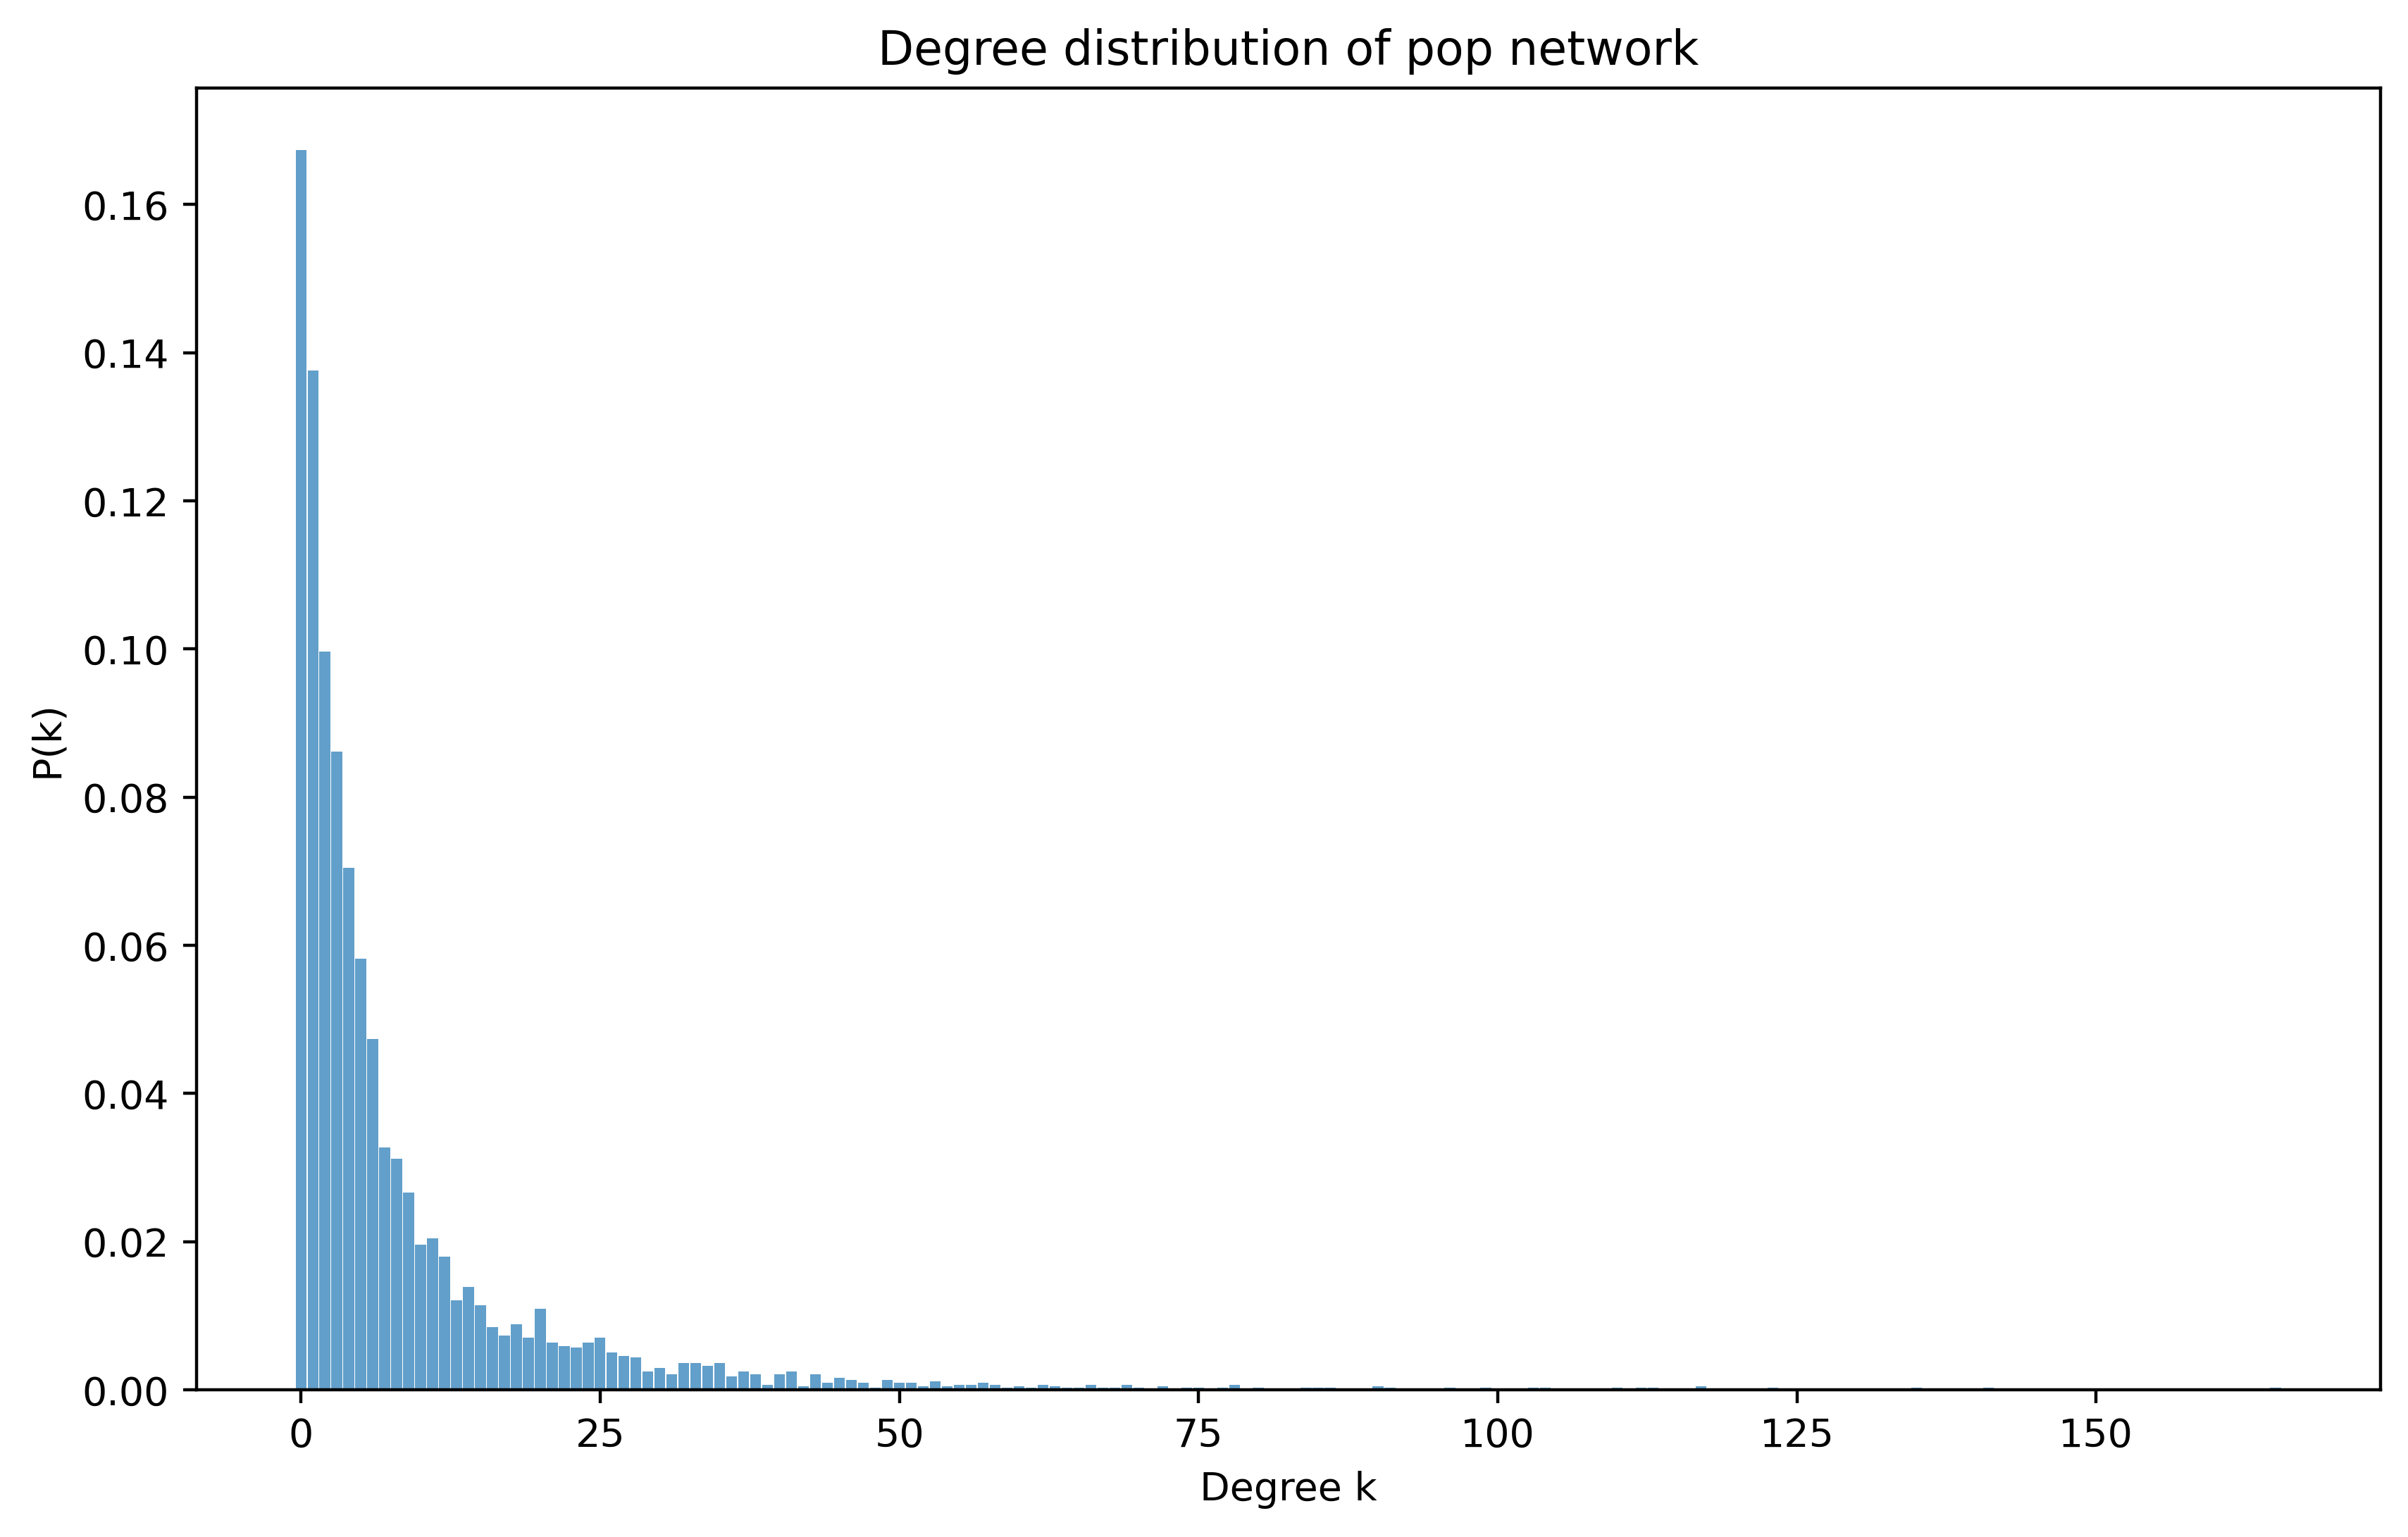

In [ ]:
plot_degree_distribution(G_pop)

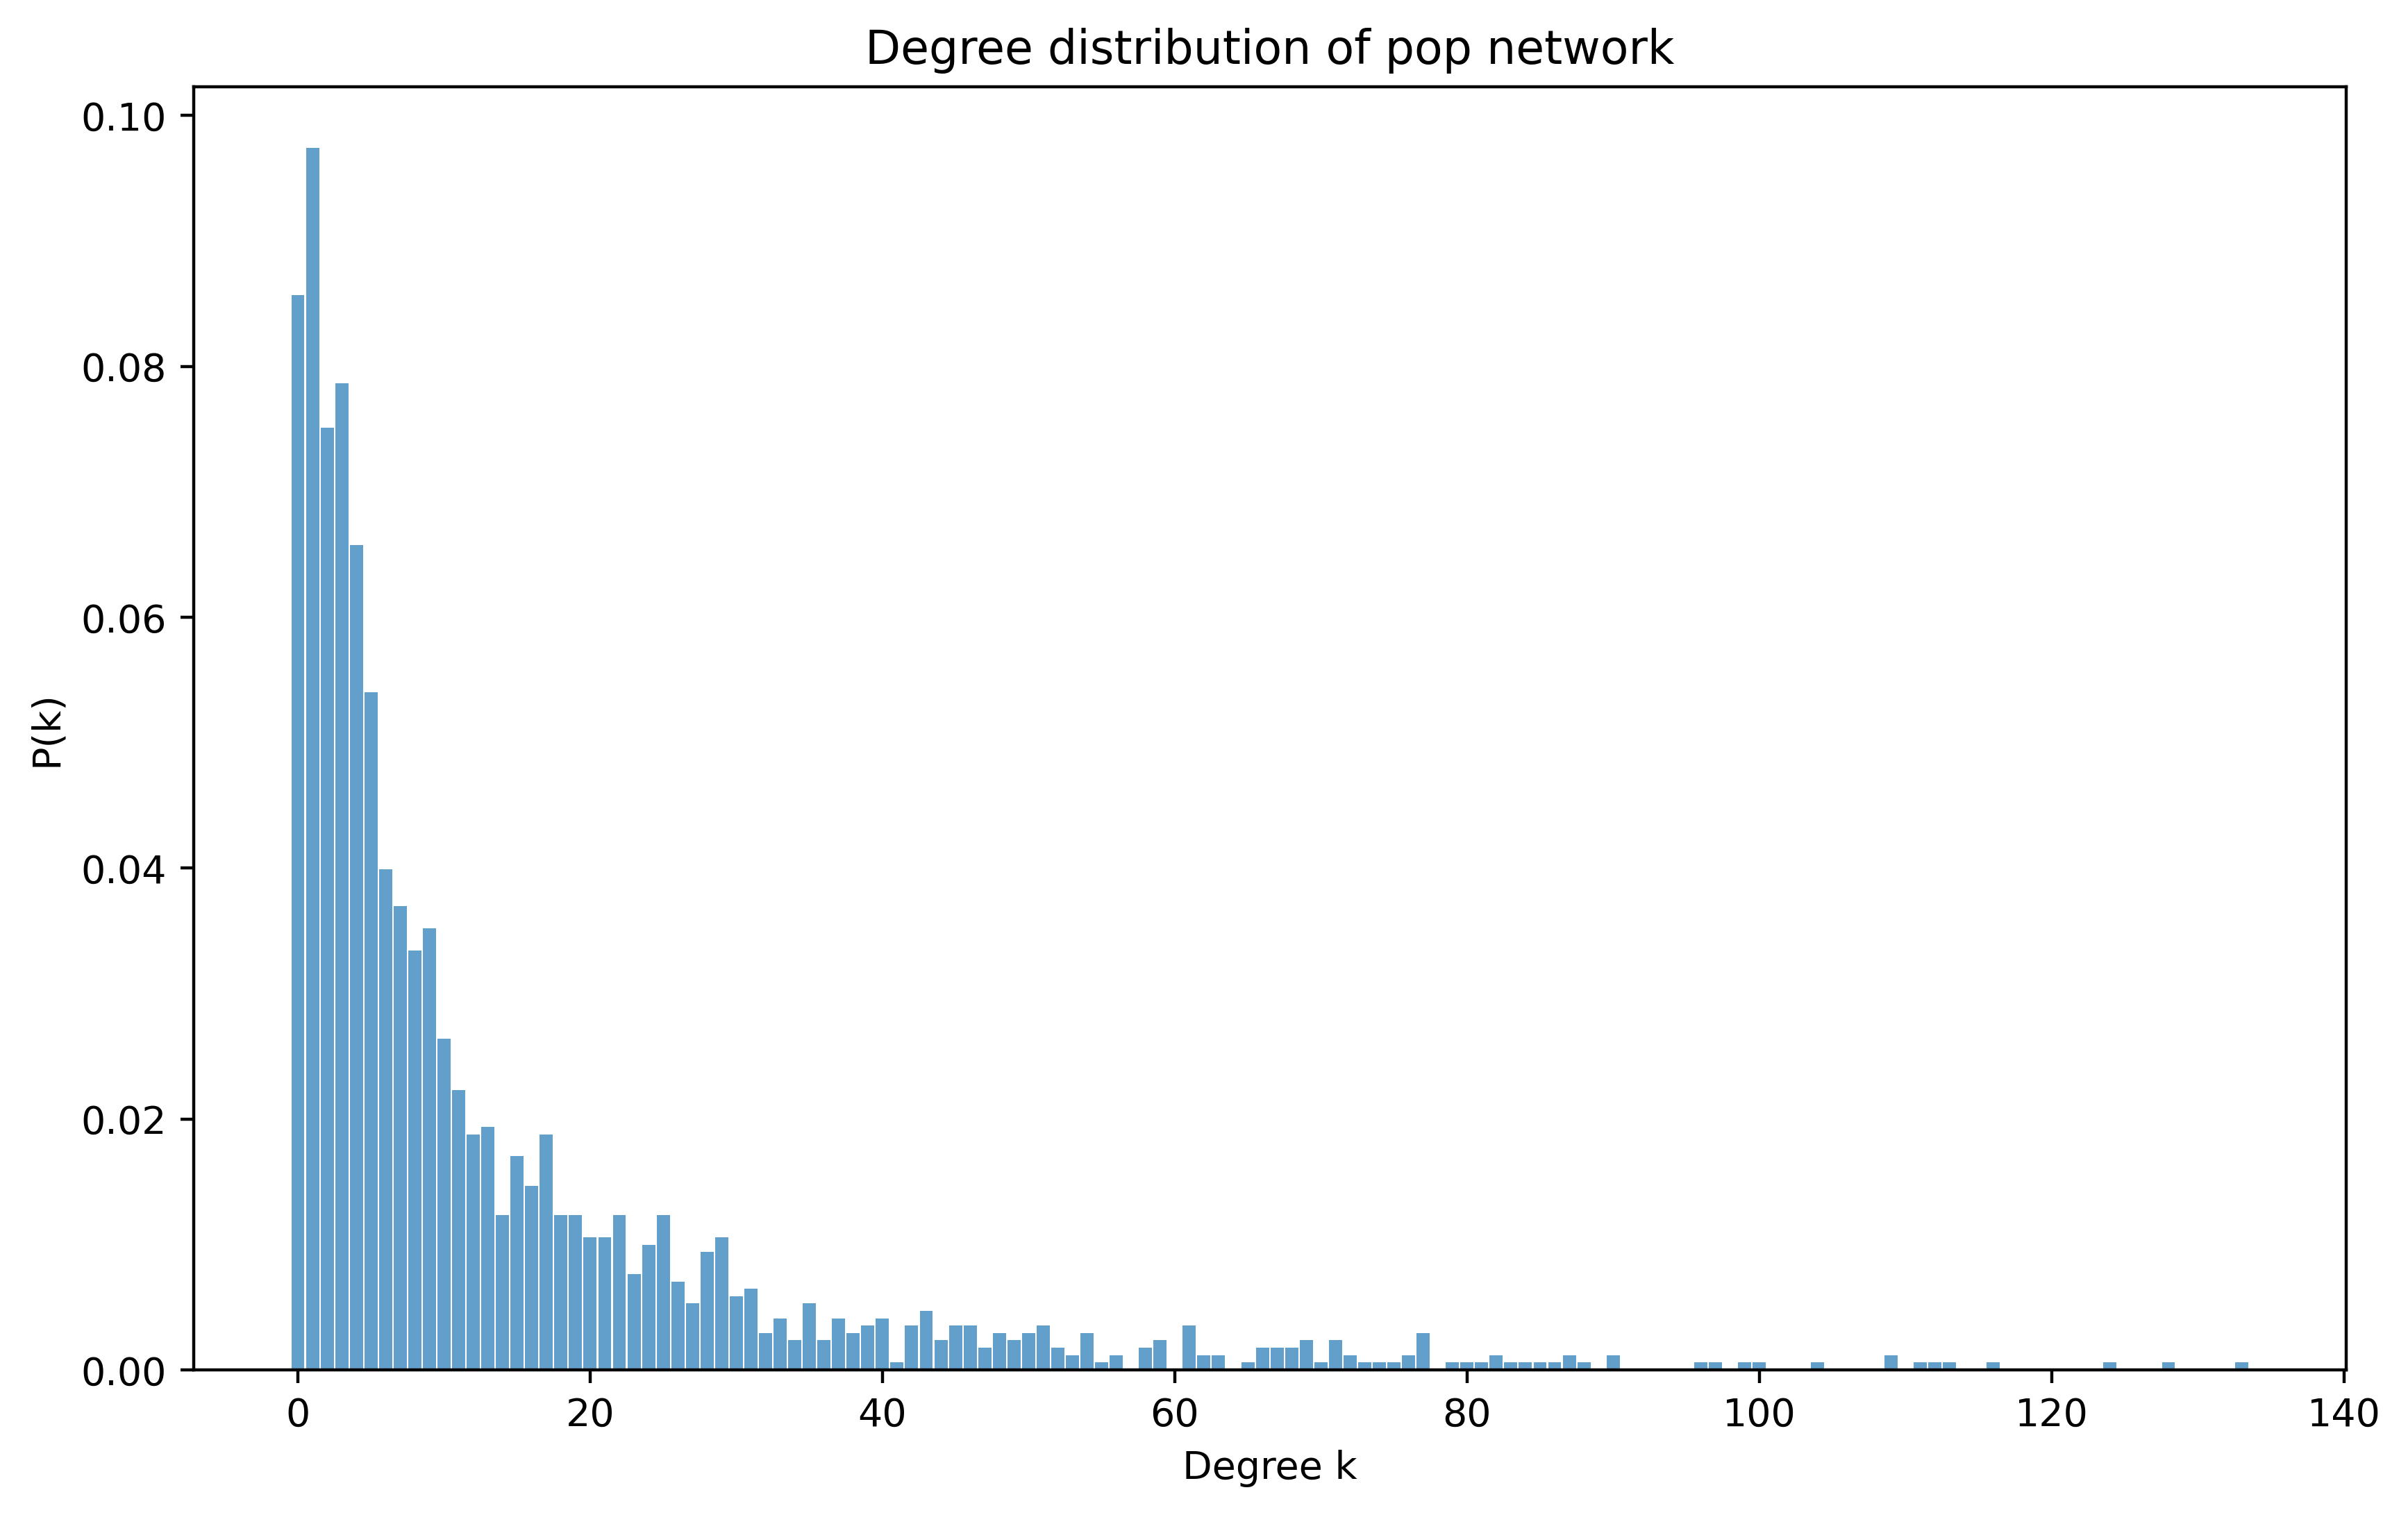

In [ ]:
plot_degree_distribution(G_rap)

In [ ]:
from Network_statistics import plot_degree_distribution_log_log_scale

Power-law exponent: 1.866


c:\Users\teisa\OneDrive\Skrivebord\DTU\semester 4\Computational Social Science\02467-Project-assignment\Network_statistics.py:85: RuntimeWarning: divide by zero encountered in power
  plt.plot(unique_degrees, C * unique_degrees ** gamma, 'k-', label=r'Power law $P(k) \sim k^{-\gamma}$')


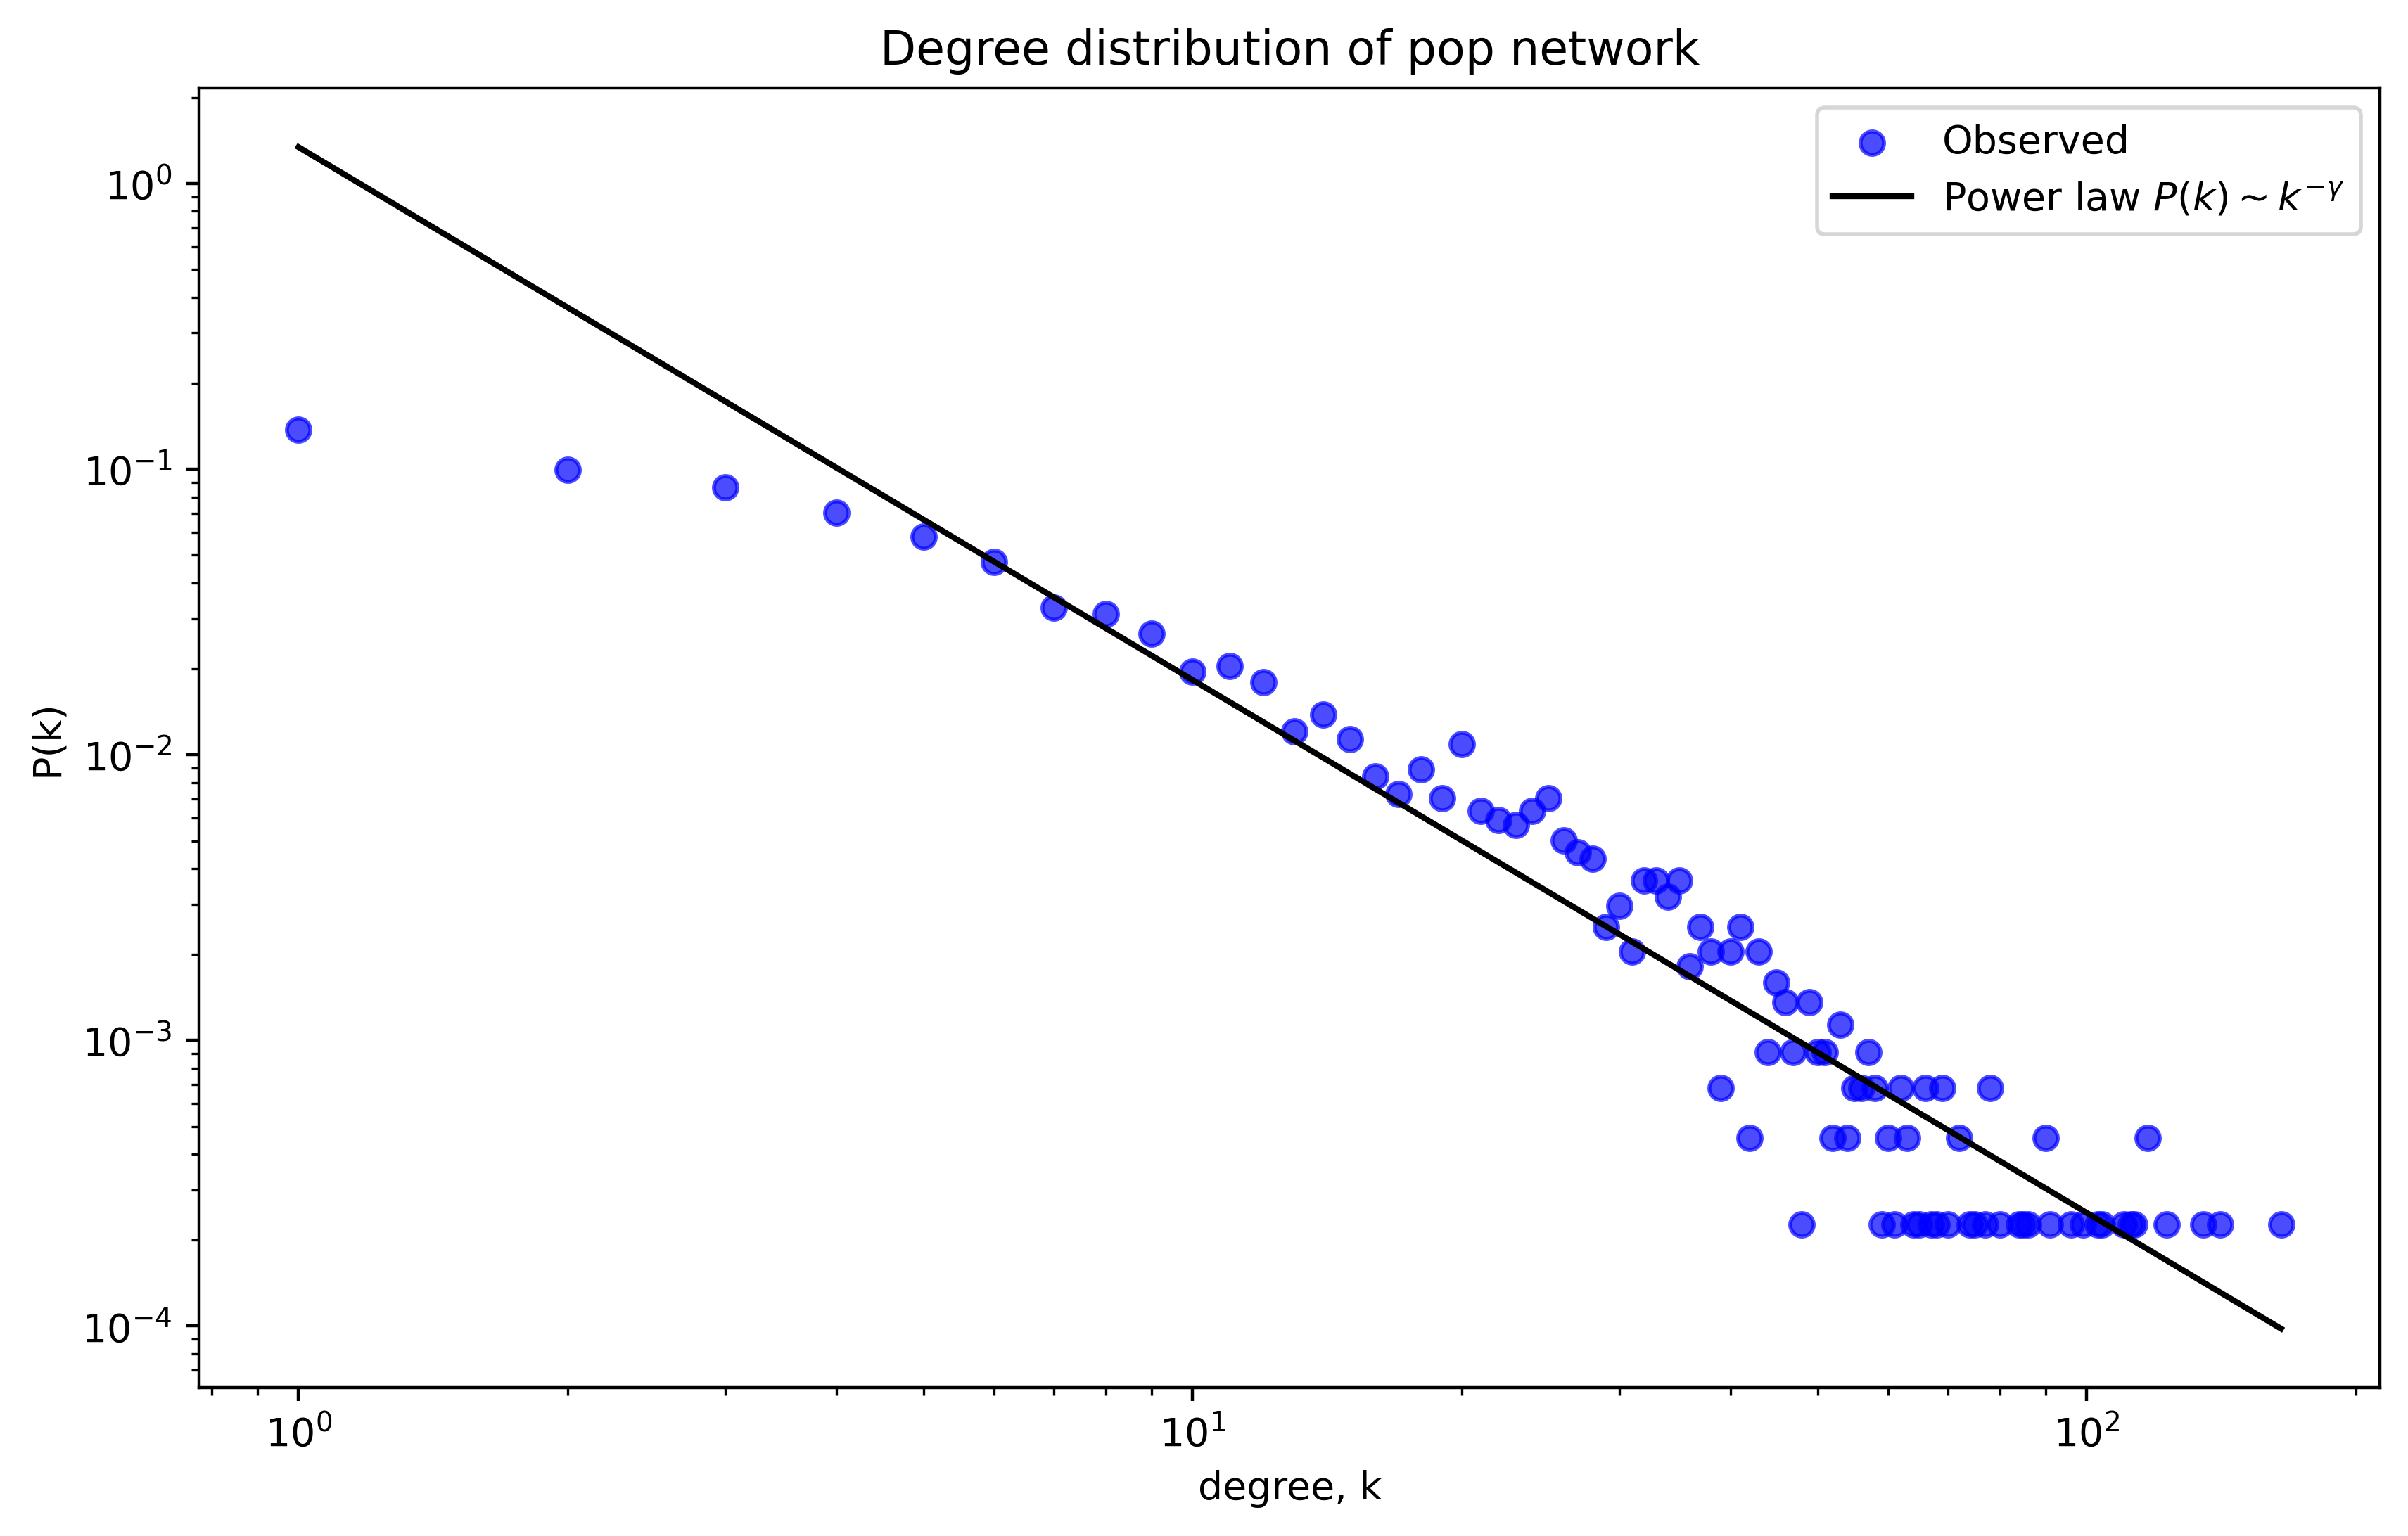

In [ ]:
plot_degree_distribution_log_log_scale(G_pop)

Power-law exponent: 1.501


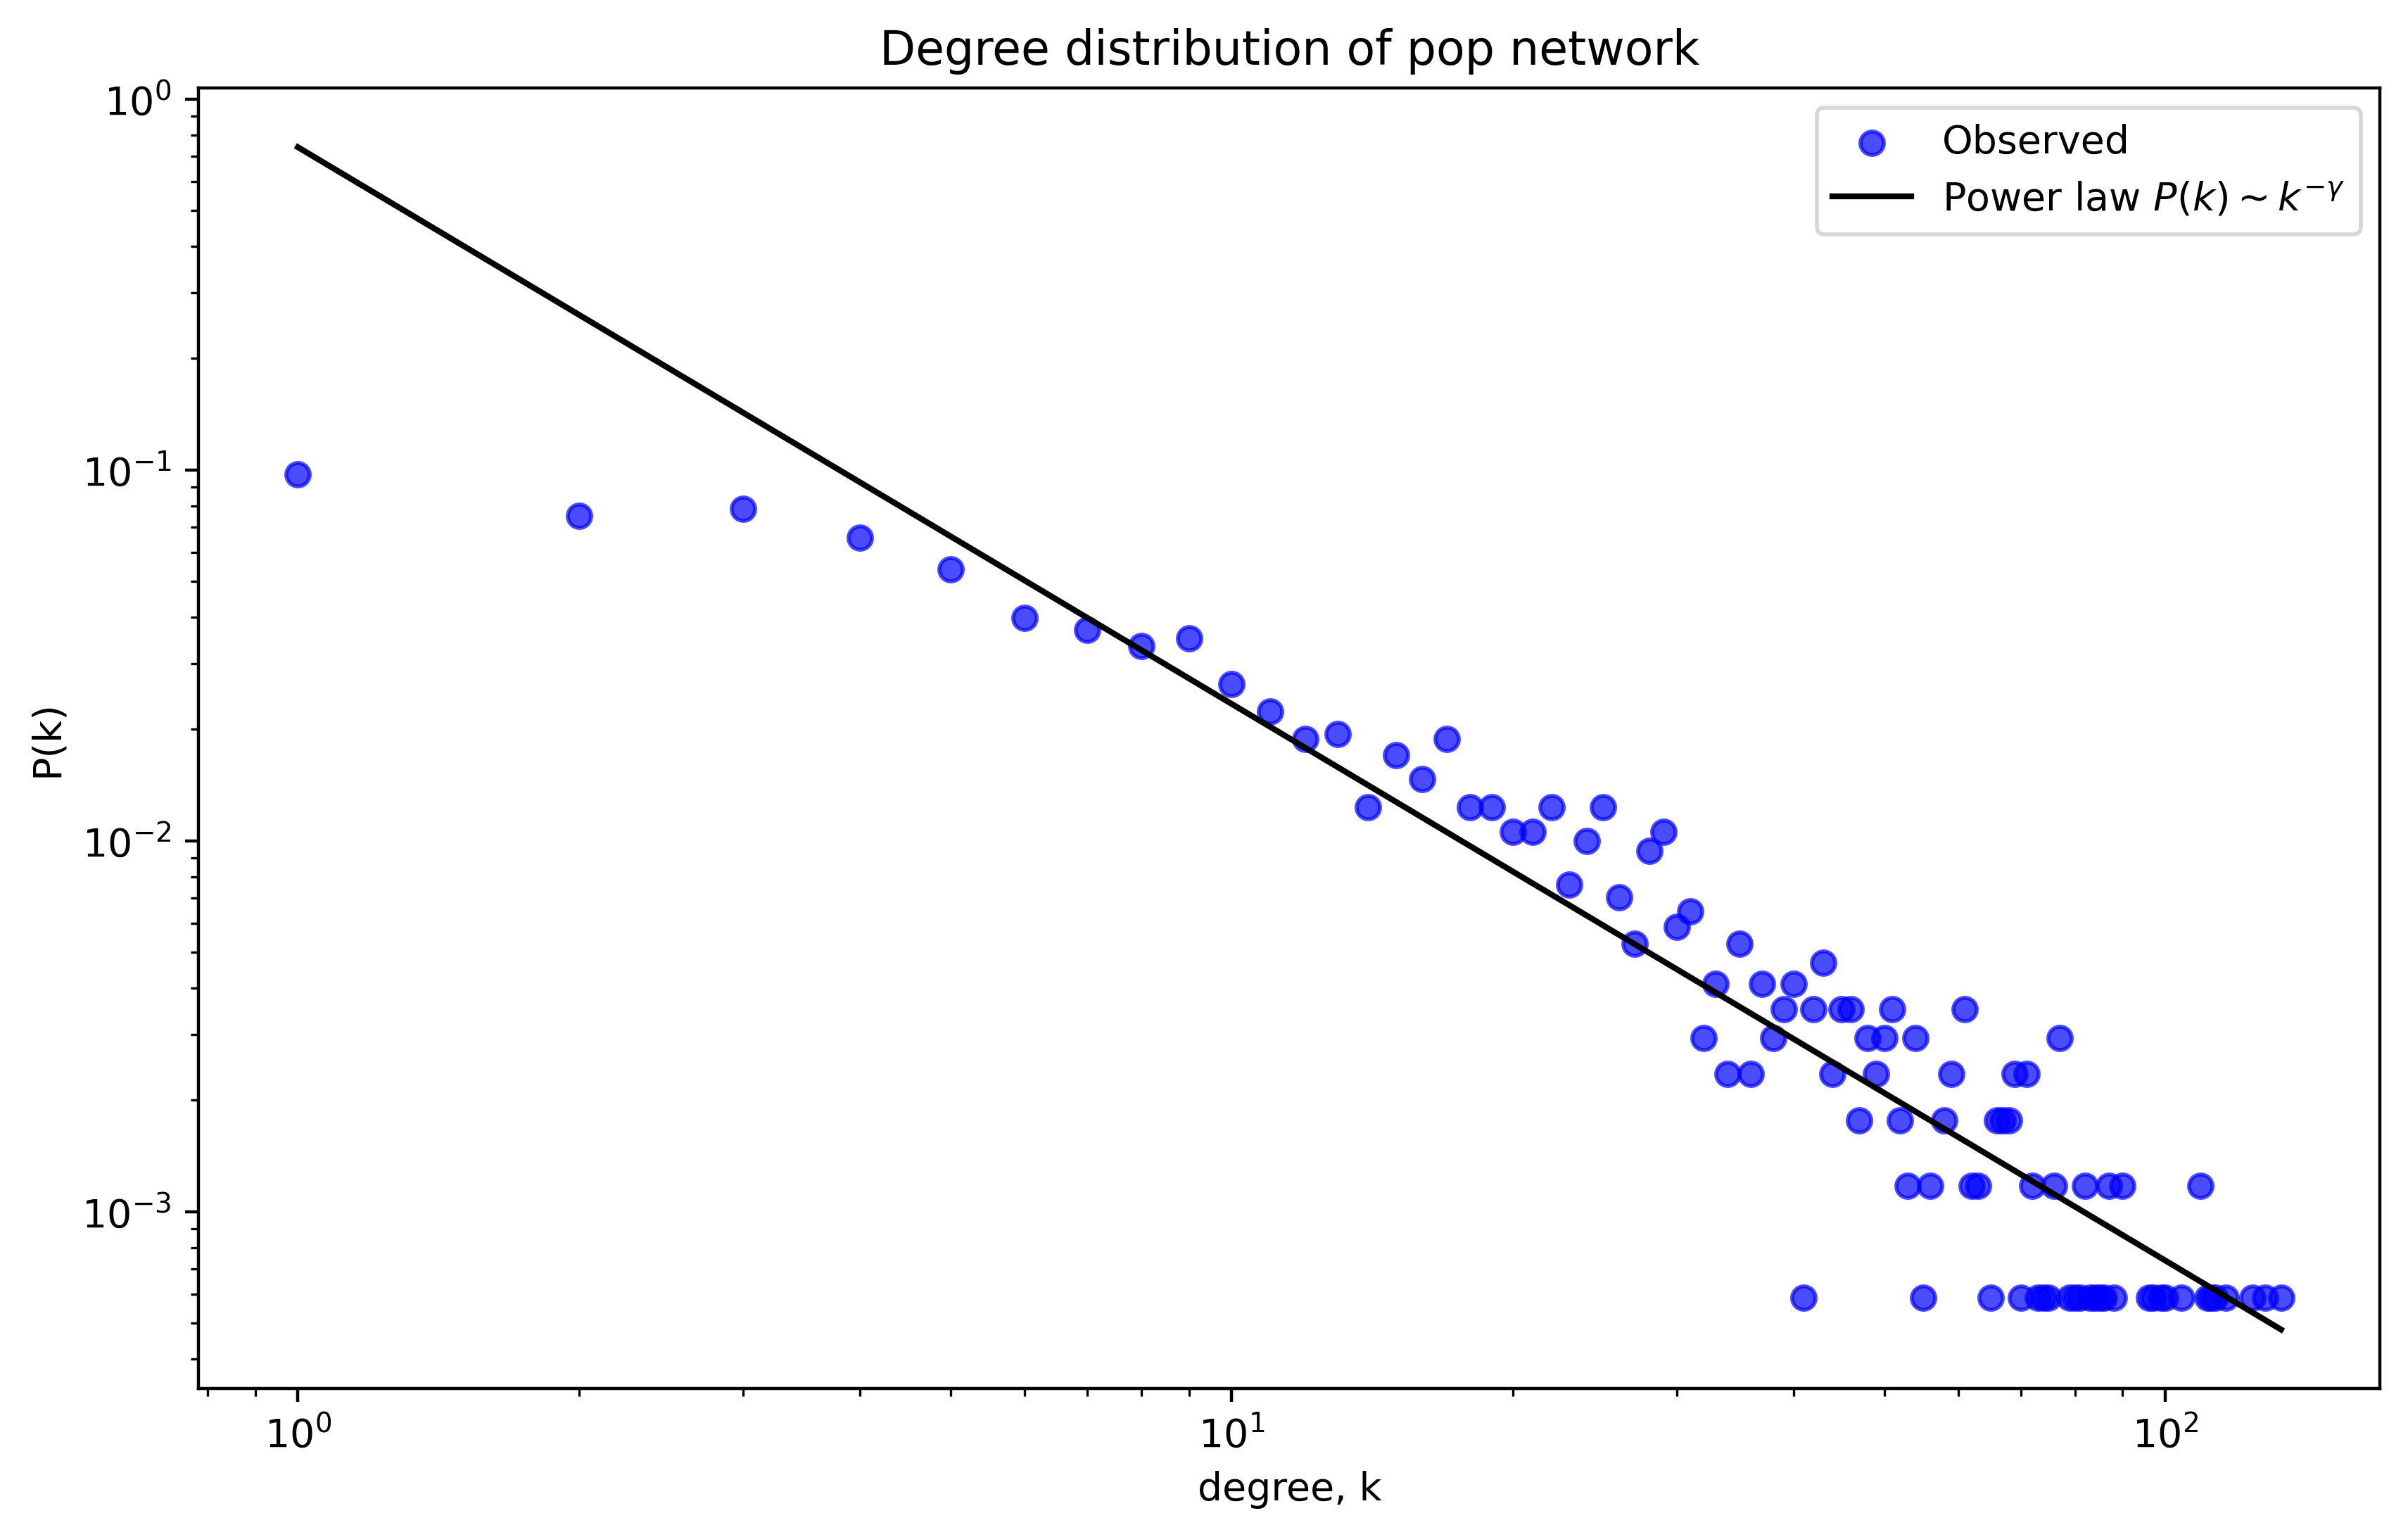

In [ ]:
plot_degree_distribution_log_log_scale(G_rap)

## North America Graphs

In [17]:
from utilities.Network_construction_functions import get_community_subgraph

G_rap_communities = community_louvain.best_partition(G_rap, random_state=10)
counts = Counter(G_rap_communities.values())
most_common_community = counts.most_common(1)[0][0]

G_rap_NA = get_community_subgraph(G_rap, most_common_community, G_rap_communities)

G_pop_communities = community_louvain.best_partition(G_pop, random_state=10)
counts = Counter(G_pop_communities.values())
most_common_community = counts.most_common(1)[0][0]

G_pop_NA = get_community_subgraph(G_pop, most_common_community, G_pop_communities)

print(len(G_pop_NA), len(G_rap_NA))

810 345


## Text gathering

To allow for an analysis of the artists lyrics across the genres, we need to retrieve songtext for all the artists. 

To handle this task we decided to use the geniuslyrics API, allowing us to retrieve lyrics for each artists top 3 songs 

In [ ]:
import lyricsgenius
import concurrent.futures 

token = "SQ5PQucPjwa_LEDaobBQyxewdh80ZB-KhaBau73yASMRNIvnijWprQSi6ZDnUb7N"
genius = lyricsgenius.Genius(token, verbose=False)

From reading the geniuslyrics documentation and our initial tests, we discovered that each request runs pretty slowly. This is due to how the geniuslyrics library recoveres the text, which is by scraping the genius site.

To work around this, we implement a genius search function and a method for running parallel.

In [ ]:
def search_artists_songs(artist_name): 
    try:
        dic = {"name": artist_name, "lyrics": []}
        result = genius.search_artist(artist_name, max_songs=3, sort="popularity")
        for song in result.songs: 
            dic["lyrics"].append(song.lyrics)
        print("#")
        return dic
    
    except Exception as e:
        print(f"Error fetching artist {artist_name}: {e}")
        return None

def parallel(chosen_list): 
    #Parallel implementation
    for i in range(0, len(chosen_list), 5): 
        print(f"Batch {i//5 + 1} / {len(chosen_list)//5}")

        if i != 0:
            print(f"{(i/5)} / {len(chosen_list)/5 -1}")
        names = chosen_list[i:i+5]

        with concurrent.futures.ThreadPoolExecutor() as executor: 
            tmp = list(executor.map(search_artists_songs, names))
        results += tmp

    df = pd.DataFrame(results)

    with open("Missing1.pkl", "wb") as f: 
        pickle.dump(df, f)
    return df

In [ ]:
chosen_list = pop_df["name"] + rap_df["name"]
print("Length of set of names: ", len(chosen_list))
results = []

Length of set of names:  5310


In [72]:
all_lyricsdf = pd.read_csv("all_lyrics.csv") #Loading manually since computing this will take many hours otherwise

In [ ]:
print(len(all_lyricsdf))
print(len(all_lyricsdf["name"].unique()))

5922
5162


In [73]:
def remove_duplicates_keep_longest_lyrics(df):
    # Drop rows with missing lyrics or name
    df = df.dropna(subset=["name", "lyrics"]).copy()

    # Compute length of lyrics
    df["lyrics_length"] = df["lyrics"].apply(len)

    # Sort by name and lyrics_length descending
    df_sorted = df.sort_values(by=["name", "lyrics_length"], ascending=[True, False])

    # Drop duplicates, keeping the one with the longest lyrics
    df_deduped = df_sorted.drop_duplicates(subset="name", keep="first")

    # Drop the helper column
    df_deduped = df_deduped.drop(columns="lyrics_length")

    return df_deduped

all_lyricsdf = pd.read_csv("all_lyrics.csv")
cleaned_df = remove_duplicates_keep_longest_lyrics(all_lyricsdf)

print("Original:", len(all_lyricsdf))
print("Unique after cleanup:", len(cleaned_df))

Original: 5922
Unique after cleanup: 5162


In [68]:
all_lyricsdf["literal_lyrics"] = all_lyricsdf["lyrics"].apply(ast.literal_eval)

all_lyricsdf["empty"] = all_lyricsdf["literal_lyrics"].apply(lambda lyrics : len(lyrics) == 0)

all_lyricsdf[all_lyricsdf["empty"] == True]

name lyrics literal_lyrics  empty
199         Evan Yo     []             []   True
214   Dato' DJ Dave     []             []   True
241       Kayee Tam     []             []   True
296    Shweta Mohan     []             []   True
297         NICECNX     []             []   True
...             ...    ...            ...    ...
5857             余枫     []             []   True
5884         Hiplin     []             []   True
5886     Alia Bhatt     []             []   True
5895           Audy     []             []   True
5908     Ted Nights     []             []   True

[106 rows x 4 columns]

**Brug af Genius:**

# Text analysis

The following section implements and applies all necessary steps for WordClouds using TF-IDF on a graph of artists. It outlines and explains how the process is done with reasoning.

### Introduction of TF-IDF

TF calculates the fraction of a term in a document.

$$TF(t,d) = \frac{f_{t,d}}{\sum_{t' \in d}(f_{t',d})}$$

where $f_{t,d}$ is the count of term $t$ in document $d$.

IDF is calculated as

$$
\text{IDF}(t, d) = \log \left( \frac{N}{\left| \left\{ d \in D \mid t \in d \right\} \right|} \right)
$$

where N is the count of documents in the entire corpus. and $ \left\{ d \in D \mid t \in d \right\} $ is the set of documents containing term t. $\left| \left\{ d \in D \mid t \in d \right\} \right|$ is then the count of documents containing the term t. Summarized IDF returns the log inverse fraction of documents containing the term t in the corpus D.

Combined as the product of the two they give the TF-IDF

$$TFIDF(t,d,D) = tf(t,d)\cdot idf(t,D)$$

This function combines a terms importance within a single document (its internal representation) with its overall significance across the corpus.

### Preprocessing of Lyrics Data

Preprocessing is applied on a copy of the original dataframe to preserve the original data.

- Rows with empty lyrics are assumed to be dropped before this step, as these represent artists whose lyrics could not be fetched via the Genius API.

- The `clean_lyrics_and_apply_representative_text` function combines all lyrics of each artist into a single, semantically representative string.

The text is cleaned in the following ways:
- Removes metadata such as `"Read More\xa0\n"` and the first line (often the title).
- Strips structural tags like `[Verse]`, `[Chorus]`, etc.
- Removes quoted commentary at the beginning of the lyrics.
- Filters out non-letter characters, leaving only alphabetic characters and whitespace.
- Cleans escaped characters (`\n`, `\r`) 
- Removes all whitespace.
- Converts the text to lowercase.

This results in a clean, lowercase string for each artist, ready for semantic analysis.

### Tokenization of Representative Lyrics

After cleaning the lyrics, each artist’s representative text is transformed into a list of tokens through the following process:

- **Stemming and Stopword Removal**: Words are reduced to their stems using a Snowball stemmer. Common English and domain-specific stopwords (e.g., "lyrics", "chorus") are removed.
- **Bigram Detection**: Frequent word pairs (bigrams) are extracted using the chi-squared statistic. Only pairs occurring more than 50 times and with p-value < 0.001 are kept.
- **Retokenization**: Statistically significant bigrams are merged into single tokens using an MWETokenizer for example "hip_hop".

The result is a structured token representation of each artist that can be used for analysis such as TF-IDF and WordClouds.


In [74]:
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)

# Ensure consistent column names (optional but helpful)
cleaned_df = cleaned_df.rename(columns={'name': 'Name'})

# Perform the merge on the 'Name' column
artists_with_lyrics = pd.merge(cleaned_df, artists_us_df, on='Name', how='inner')  # or how='left'/'right'/'outer'
artists_with_lyrics["lyrics"] = artists_with_lyrics["lyrics"].apply(ast.literal_eval)

artists_with_lyrics = artists_with_lyrics.rename(columns={"Name":"name"})
artists_with_lyrics = artists_with_lyrics.rename(columns={"Followers":"followers"})

G_rap_NA # Network used for analysis
rap_communities = community_louvain.best_partition(G_rap_NA)

print(len(artists_with_lyrics))

artists_with_lyrics.head(2)

5163


name                                             lyrics  \
0       $hirak  [12 ContributorsMiljonair Lyrics“Miljonair” is...   
1  $uicideboy$  [184 ContributorsTranslationsTürkçeItalianoFra...   

                       ID Gender  Age Country  \
0  1uUuCEXmWpKN2YLl5xSoT2   male   26      NL   
1  1VPmR4DJC1PlOtd0IADAO0  mixed    0      US   

                                              Genres  Popularity  followers  \
0                 ['dutch hip hop', 'dutch rap pop']          56     116752   
1  ['cloud rap', 'dark trap', 'new orleans rap', ...          84    6449698   

                                     URI  
0  spotify:artist:1uUuCEXmWpKN2YLl5xSoT2  
1  spotify:artist:1VPmR4DJC1PlOtd0IADAO0

In [75]:
from utilities.text_analysis import clean_lyrics_and_apply_representative_text, filter_for_english_language, tokenize

In [76]:
rap_artists_df = artists_with_lyrics.copy()
rap_artists_df_prepared = rap_artists_df.copy()

amounts_of_artists_with_lyrics = 0
artist_names = set(rap_artists_df_prepared["name"])

for node in G_rap_NA.nodes():
    if node in artist_names:
        amounts_of_artists_with_lyrics += 1

print(f"There exists {amounts_of_artists_with_lyrics}/{len(G_rap.nodes())} artists in the Rap graf containing lyrics")

rap_artists_df_prepared = clean_lyrics_and_apply_representative_text(rap_artists_df_prepared)
rap_artists_df_prepared  = tokenize(rap_artists_df_prepared)

rap_artists_df_prepared.head(2)

There exists 311/1149 artists in the Rap graf containing lyrics


name                                             lyrics  \
0       $hirak  [12 ContributorsMiljonair Lyrics“Miljonair” is...   
1  $uicideboy$  [184 ContributorsTranslationsTürkçeItalianoFra...   

                       ID Gender  Age Country  \
0  1uUuCEXmWpKN2YLl5xSoT2   male   26      NL   
1  1VPmR4DJC1PlOtd0IADAO0  mixed    0      US   

                                              Genres  Popularity  followers  \
0                 ['dutch hip hop', 'dutch rap pop']          56     116752   
1  ['cloud rap', 'dark trap', 'new orleans rap', ...          84    6449698   

                                     URI  \
0  spotify:artist:1uUuCEXmWpKN2YLl5xSoT2   
1  spotify:artist:1VPmR4DJC1PlOtd0IADAO0   

                                 representative_text  \
0  een miljonair mn pa zei hij weet dat het goed ...   
1  its not fair i found love it made me say that ...   

                                              tokens  
0  [een, miljonair, mn, pa, zei, hij, weet_dat, h...  
1  [fair, found, love_made, say, get_back, youll_...

### Community-Based TF-IDF Analysis and WordCloud Visualization

This analysis explores linguistic patterns across artist communities using TF-IDF scores to extract key terms for each group and visualise them through word clouds. The process involves grouping, transforming, and analysing preprocessed lyrics data.


In [77]:
from utilities.text_analysis import prepare_community_texts, get_top_n_largest_community_ids, get_TF_dataframe

from utilities.text_analysis import get_IDF_dataframe,get_TF_IDF_dataframe,print_top_5_TF_per_community,print_top_10_tf_idf_tokens

from utilities.text_analysis import  get_community_to_top_n_artists_by_followers, plot_wordcloud, run_tf_idf_wordcloud_analysis

#### 1. Grouping Lyrics by Community

We begin by aggregating tokenized lyrics at the **community level** using the `prepare_community_texts()` function:

Next, we extract the top 5 largest communities, where "largest" is defined by the number of artists assigned to each community.

In [78]:
print(f"{len(rap_artists_df)} artists in the rap dataframe")
print(f"{len(rap_artists_df_prepared)} artists in the rap dataframe containing lyrics")
print(f"{len(set(rap_communities.values()))} unique communities in the rap network - using louvain ")

rap_community_texts_df = prepare_community_texts(rap_artists_df_prepared, rap_communities)

rap_top_5_community_ids = get_top_n_largest_community_ids(rap_communities, 5)

rap_top_5_community_texts_df = rap_community_texts_df[rap_community_texts_df["community"].isin(rap_top_5_community_ids)]

rap_top_5_community_texts_df = rap_top_5_community_texts_df.sort_values(
    by="community",
    key=lambda col: col.map({cid: i for i, cid in enumerate(rap_top_5_community_ids)})
)

print(f"Top 5 communities by amount of members")

rap_top_5_community_texts_df

5163 artists in the rap dataframe
5163 artists in the rap dataframe containing lyrics
5 unique communities in the rap network - using louvain 
Top 5 communities by amount of members


community                                             tokens  tokens_length
4        4.0  [singl, teas, octob, via, instagram, post, fea...          82595
1        1.0  [throughout, track, two, read, ohohoh, yeah_ye...          79510
0        0.0  [fair, found, love_made, say, get_back, youll_...          70679
2        2.0  [love, turn, headphon, littl_bit, yeah, mani, ...          29409
3        3.0  [mac, p, boy, pussi, need, maxi, mac, p, nigga...          14554

#### 2. Calculating TF, IDF, and TF-IDF Scores

With the top 5 communities selected, we now calculate word importance within and across communities using Term Frequency (TF), Inverse Document Frequency (IDF), and TF-IDF scores.


In [79]:
rap_tf_df = get_TF_dataframe(rap_top_5_community_texts_df)
rap_idf_df = get_IDF_dataframe(rap_community_texts_df)
rap_TF_IDF_df = get_TF_IDF_dataframe(rap_tf_df, rap_idf_df)

print("---Top 5 terms in Rap communities using TF---")        
print_top_5_TF_per_community(rap_tf_df)

print("---Top 5 terms in Rap communities using TF-iDF---")        
print_top_10_tf_idf_tokens(rap_TF_IDF_df)


---Top 5 terms in Rap communities using TF---
25 terms
Community: 0.0, 5 Terms: ['like', 'im', 'bitch', 'nigga', 'got']
Community: 1.0, 5 Terms: ['like', 'im', 'nigga', 'got', 'bitch']
Community: 2.0, 5 Terms: ['got', 'yeah', 'bitch', 'like', 'im']
Community: 3.0, 5 Terms: ['im', 'bitch', 'got', 'nigga', 'like']
Community: 4.0, 5 Terms: ['im', 'nigga', 'like', 'got', 'bitch']
---Top 5 terms in Rap communities using TF-iDF---
50 terms
Community: 0.0, 10 Terms: ['take_chanel', 'caus_fine', 'band_make', 'cocaina', 'fra', 'chyeah', 'shutdown', 'ninetyon', 'isi', 'oohohoh']
Community: 1.0, 10 Terms: ['peekaboo_peekaboo', 'mad_hoe', 'shmoney', 'ringringringin', 'skecher', 'durk_dej', 'thotiana', 'sprey', 'ik', 'op_je']
Community: 2.0, 10 Terms: ['bangbang', 'sheck_wes', 'hunnit_rack', 'bustin_wrapper', 'spend_shit', 'undivid', 'psh', 'versac_versac', 'chippi', 'push_push']
Community: 3.0, 10 Terms: ['gyal', 'ever_come', 'lef', 'inna', 'dem', 'nuh', 'fi', 'kakah', 'black_yellow', 'cyaan']
Com

#### 3. Identifying Top Artists per Community

To make the visualisation more informative we identify the **top artists by followers** in each of the 5 selected communities.

In [80]:
n=3

rap_communitiy_to_top_artists = get_community_to_top_n_artists_by_followers(rap_top_5_community_ids, rap_communities, rap_artists_df, n)

for community_id, top_artists in rap_communitiy_to_top_artists.items():
    print(f"Top {n} artists by followers in community {community_id}: {', '.join(top_artists)}")

Top 3 artists by followers in community 4: Lil Wayne, Big Sean, DJ Khaled
Top 3 artists by followers in community 1: Lil Baby, YoungBoy Never Broke Again, DaBaby
Top 3 artists by followers in community 0: J. Cole, Tyler, The Creator, A$AP Rocky
Top 3 artists by followers in community 2: Post Malone, 21 Savage, Future
Top 3 artists by followers in community 3: Wiz Khalifa, French Montana, Stefflon Don


#### 4. Visualising Community-Specific Language with Word Clouds

In the final step, we generate a **word cloud** for each of the top 5 communities using their most distinctive terms determined by TF-IDF scores.

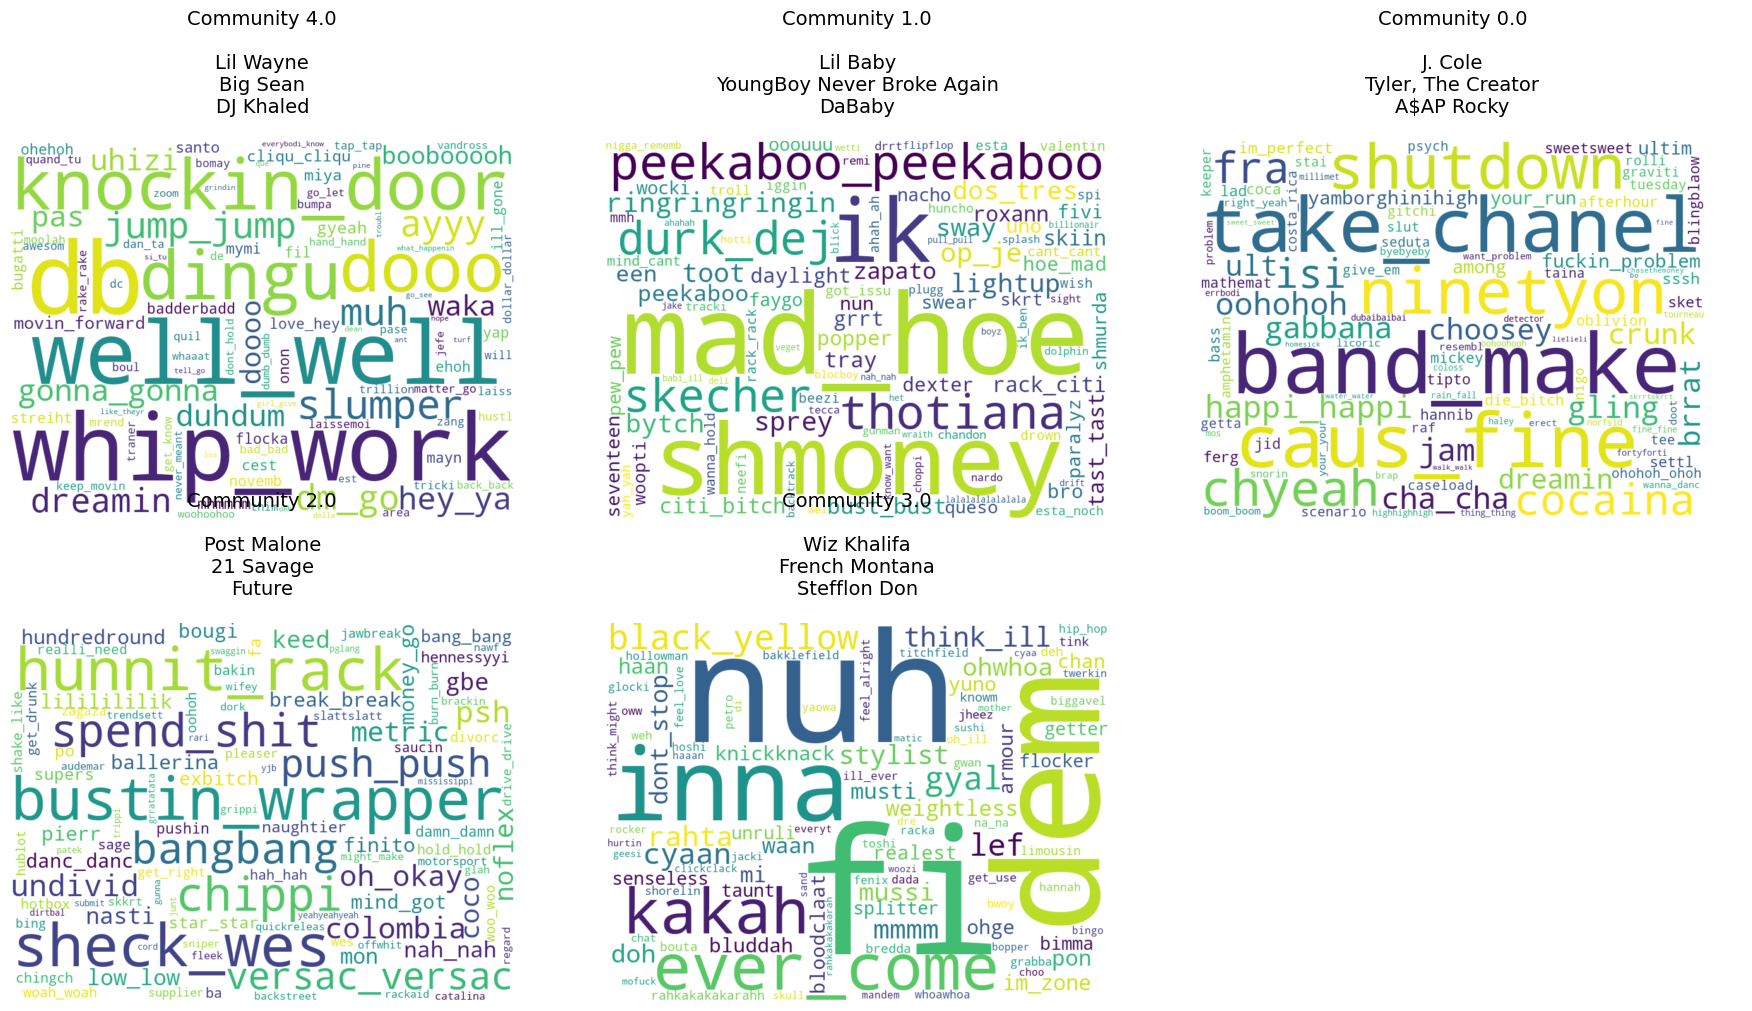

In [81]:
plot_wordcloud(rap_TF_IDF_df, rap_top_5_community_texts_df, rap_communitiy_to_top_artists)

### Running Word Cloud Analysis on Pop Network

We now apply the same TF-IDF and word cloud procedure to the **pop music artist network**


 Applying word cloud analysis on dataframe containing 5163 artists
Top 10 communities by size:
1. Community 0: 158 nodes
2. Community 7: 138 nodes
3. Community 1: 129 nodes
4. Community 2: 108 nodes
5. Community 3: 92 nodes
6. Community 4: 74 nodes
7. Community 8: 69 nodes
8. Community 6: 39 nodes
9. Community 5: 3 nodes
There exists 569/810 artists in the graf containing lyrics

 9 unique communities were found

 ---- top 5 TF terms per community ---- 

25 terms
Community: 0.0, 5 Terms: ['im', 'like', 'your', 'love', 'yeah']
Community: 1.0, 5 Terms: ['got', 'im', 'like', 'get', 'your']
Community: 2.0, 5 Terms: ['know', 'like', 'got', 'im', 'oh']
Community: 3.0, 5 Terms: ['love', 'like', 'im', 'got', 'your']
Community: 7.0, 5 Terms: ['your', 'like', 'im', 'love', 'oh']

 ---- Top 10 TF-IDf terms per community ---- 

50 terms
Community: 0.0, 10 Terms: ['dey', 'deep_low', 'lick_lick', 'aiaiai', 'life_save', 'bo', 'go_bang', 'miss_moment', 'spoon', 'yayae']
Community: 1.0, 10 Terms: ['do

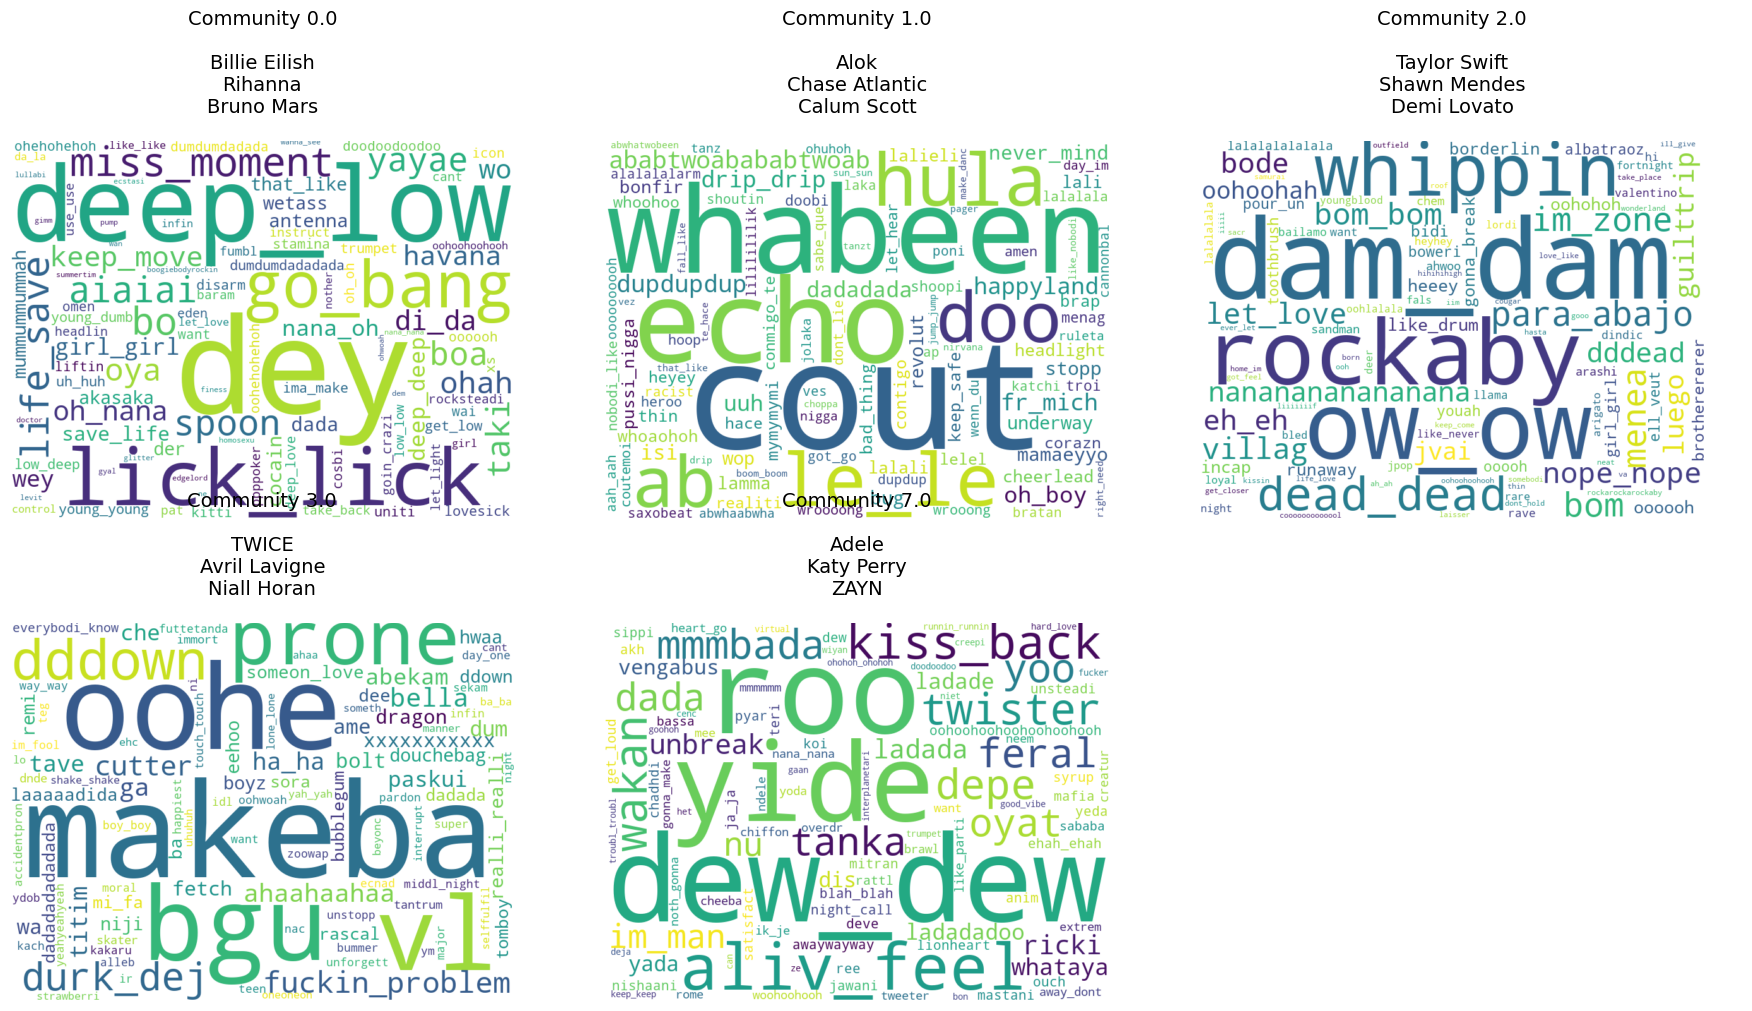

In [82]:
run_tf_idf_wordcloud_analysis(artists_with_lyrics, G_pop_NA, verbose=True)


 Applying word cloud analysis on dataframe containing 5163 artists
Top 10 communities by size:
1. Community 2: 116 nodes
2. Community 0: 105 nodes
3. Community 3: 65 nodes
4. Community 1: 31 nodes
5. Community 4: 28 nodes
There exists 187/345 artists in the graf containing lyrics

 5 unique communities were found

 ---- top 5 TF terms per community ---- 

25 terms
Community: 0.0, 5 Terms: ['im', 'nigga', 'like', 'got', 'get']
Community: 1.0, 5 Terms: ['nigga', 'im', 'got', 'like', 'get']
Community: 2.0, 5 Terms: ['nigga', 'yeah', 'got', 'bitch', 'im']
Community: 3.0, 5 Terms: ['like', 'im', 'bitch', 'shit', 'nigga']
Community: 4.0, 5 Terms: ['yeah', 'bitch', 'nigga', 'im', 'like']

 ---- Top 10 TF-IDf terms per community ---- 

50 terms
Community: 0.0, 10 Terms: ['well_well', 'dooo', 'uhizi', 'duhdum', 'jet', 'dm_go', 'jump_jump', 'ayyy', 'gonna_gonna', 'danc_danc']
Community: 1.0, 10 Terms: ['band_make', 'whip_work', 'black_yellow', 'colombia', 'moolah', 'slumper', 'metric', 'babi_wo

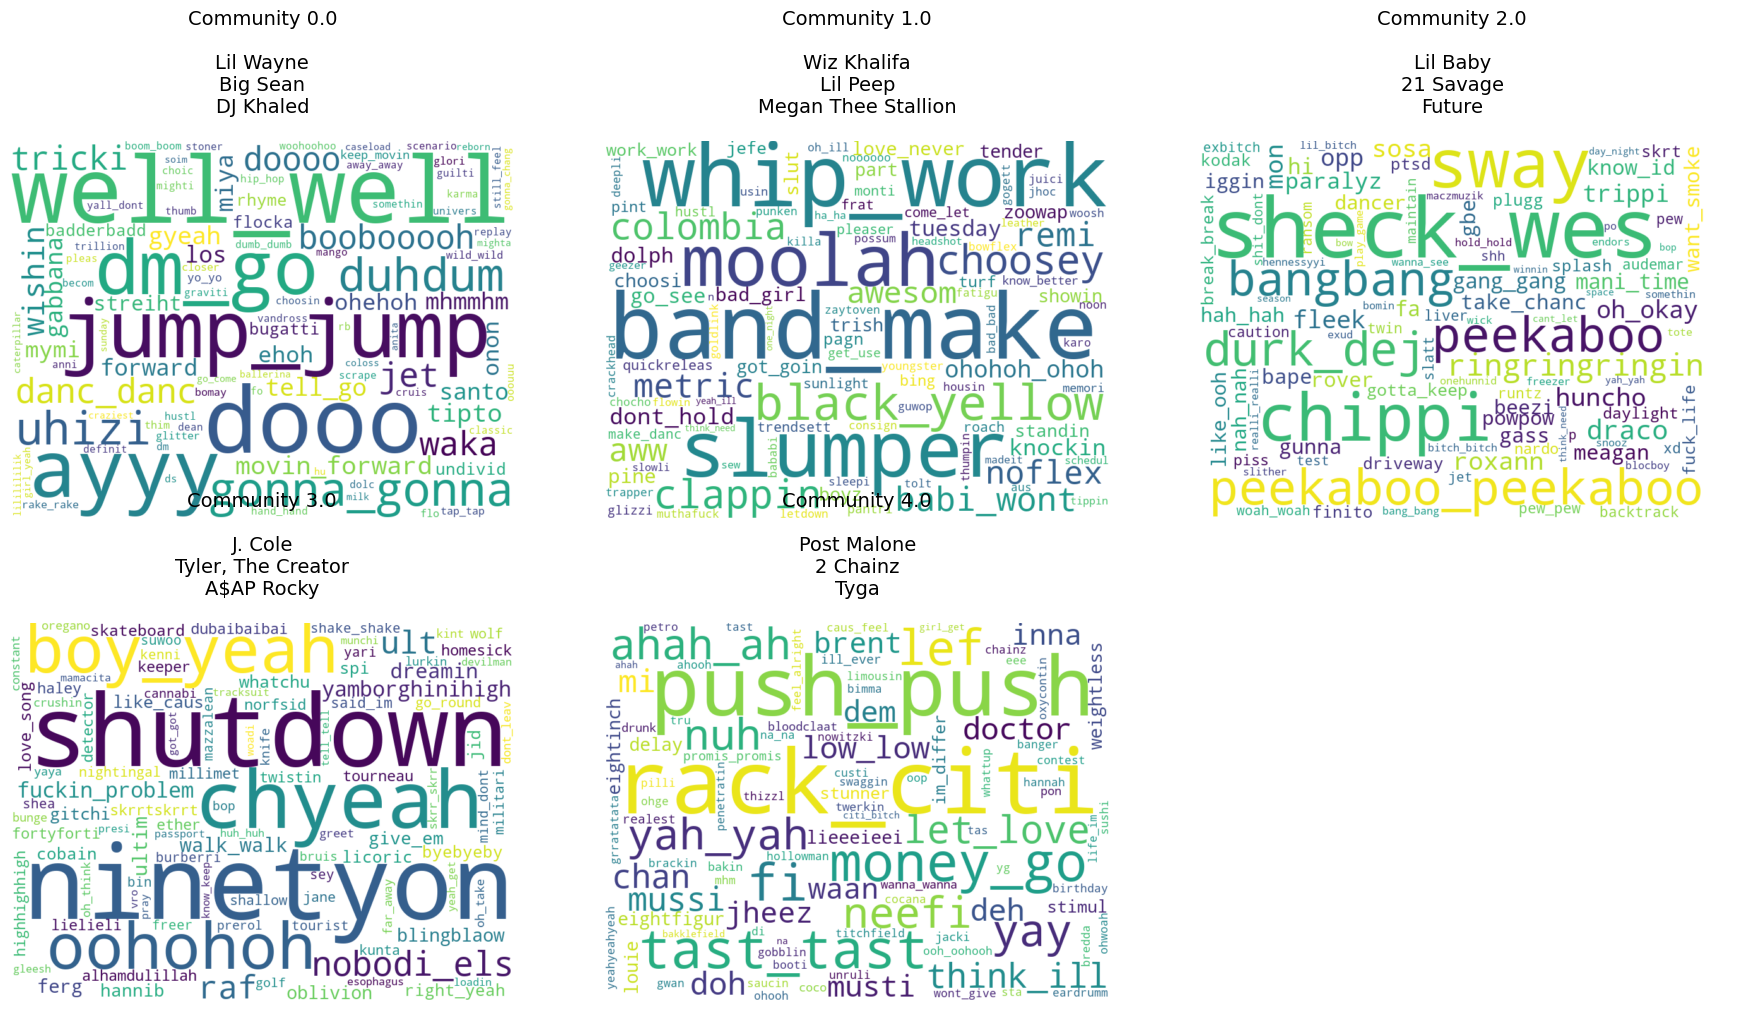

In [83]:
run_tf_idf_wordcloud_analysis(artists_with_lyrics, G_rap_NA, verbose=True, log_power=1)

### Tokenization of Representative Lyrics

After cleaning the lyrics, each artist’s representative text is transformed into a list of tokens through the following process:

- **Stemming and Stopword Removal**: Words are reduced to their stems using a Snowball stemmer. Common English and domain-specific stopwords (e.g., "lyrics", "chorus") are removed.
- **Bigram Detection**: Frequent word pairs (bigrams) are extracted using the chi-squared statistic. Only pairs occurring more than 50 times and with p-value < 0.001 are kept.
- **Retokenization**: Statistically significant bigrams are merged into single tokens using an MWETokenizer for example "hip_hop".

The result is a structured token representation of each artist that can be used for analysis such as TF-IDF and WordClouds.


### Worldcloud for only US Artists

In [ ]:
dff = pd.read_csv("most_listened_artists_in_US_dataset.csv")

In [ ]:
pop_df = pop_artists_df[pop_artists_df["name"].isin(dff[dff["Country"] == "US"]["Name"].tolist())]
rap_df = rap_artists_df[rap_artists_df["name"].isin(dff[dff["Country"] == "US"]["Name"].tolist())]
print(pop_df.shape)
print(rap_df.shape)

(535, 7)
(319, 7)


In [ ]:
print("---- Large Pop network: ----")
G_pop = get_Graph_with_names(pop_df, edges_df)
print("\n---- Large Rap network: ----")
G_rap = get_Graph_with_names(rap_df, edges_df)

    
G_pop # Network used for analysis
pop_communities = community_louvain.best_partition(G_pop)
rap_communities = community_louvain.best_partition(G_rap)


 Applying word cloud analysis on dataframe containing 535 artists

 387 artists were found containing lyrics

 163 unique communities were found

 ---- top 5 TF terms per community ---- 

25 terms
Community: 0, 5 Terms: ['like', 'im', 'got', 'yeah', 'get']
Community: 3, 5 Terms: ['know', 'like', 'im', 'love', 'yeah']
Community: 11, 5 Terms: ['like', 'know', 'oh', 'love', 'im']
Community: 14, 5 Terms: ['cant', 'im', 'la', 'know', 'wanna']
Community: 17, 5 Terms: ['im', 'yeah', 'like', 'nigga', 'got']

 ---- Top 10 TF-IDf terms per community ---- 

50 terms
Community: 0, 10 Terms: ['nigga', 'halo', 'dahm', 'bitch', 'loosen', 'ayyy', 'uh', 'miya', 'ya', 'gon']
Community: 3, 10 Terms: ['nigga', 'feelin', 'swallalala', 'yayae', 'low_low', 'dddown', 'shimmi', 'woo', 'fuck', 'hol_hol']
Community: 11, 10 Terms: ['jolen', 'whippin', 'im_man', 'durk', 'dam', 'wolf', 'kiss_back', 'aliv_feel', 'dollar', 'nana_nana']
Community: 14, 10 Terms: ['sabe', 'reggaetn', 'montana', 'ew', 'lo', 'feliz', 'mu

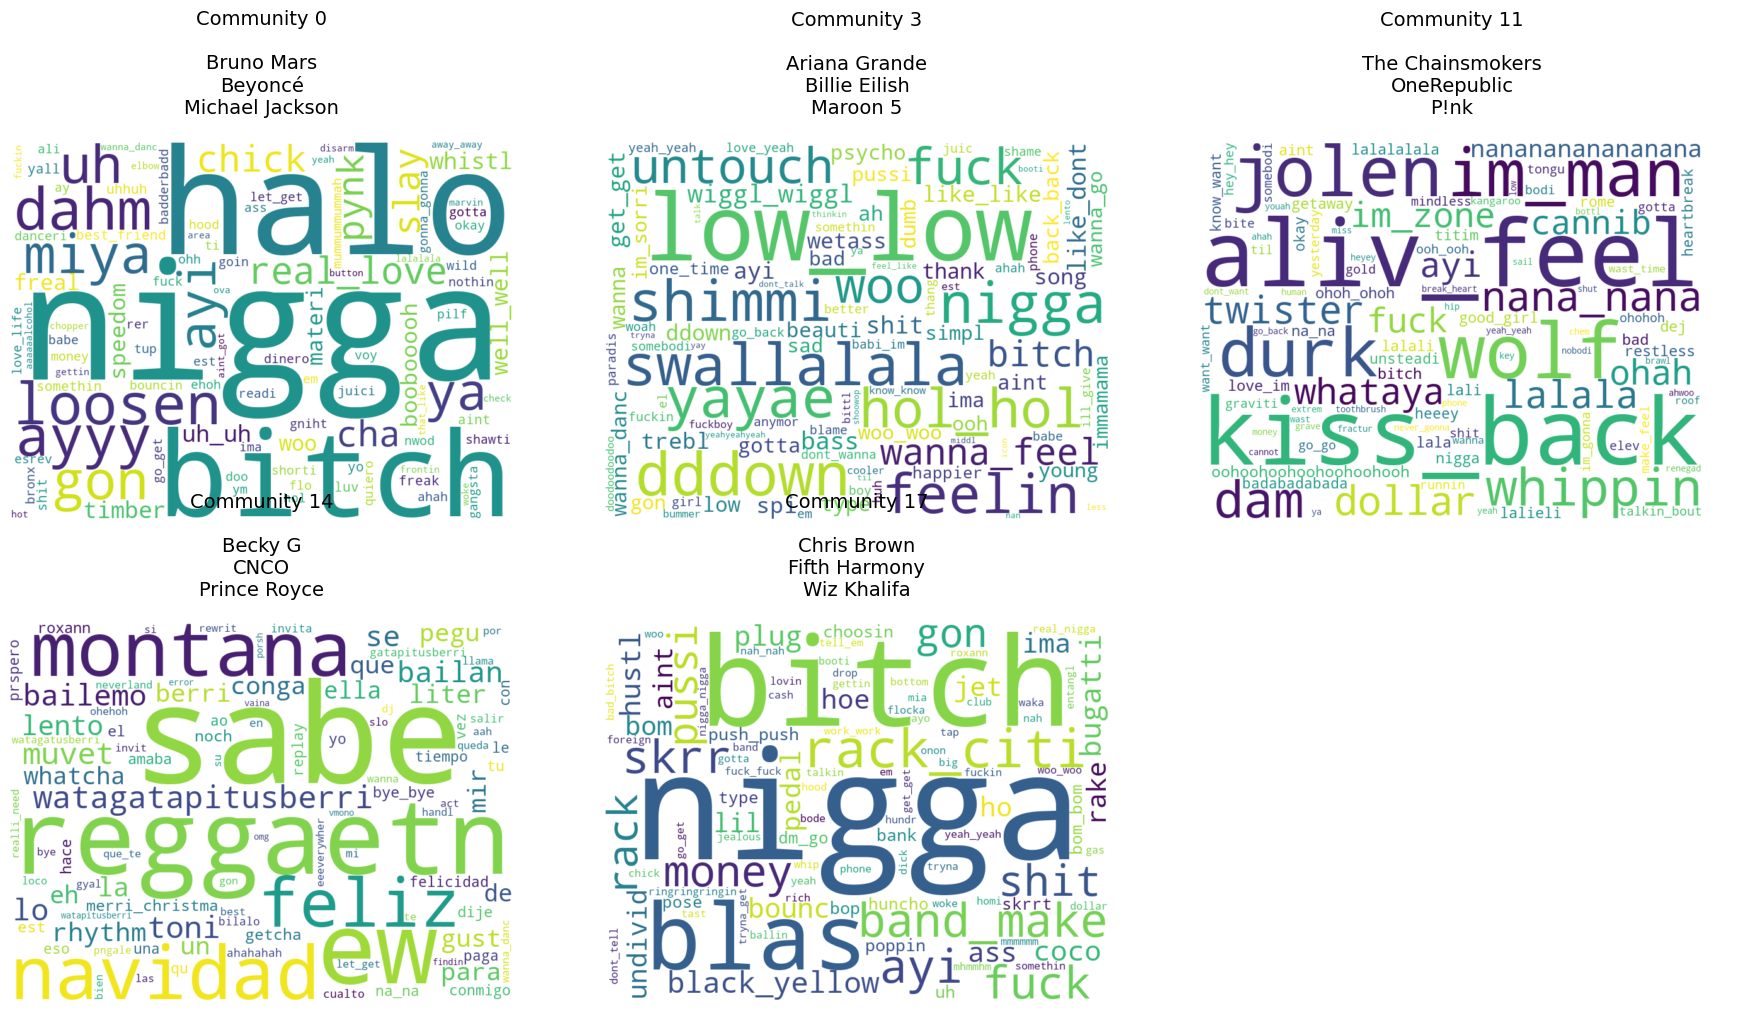

In [ ]:
run_tf_idf_wordcloud_analysis(pop_df, pop_communities, verbose=True)